So far we've covered the basics of TensorFlow and built a handful of models to work across different problems.

Now we're going to get specific and see how a special kind of neural network, convolutional neural networks (CNNs) can be used for computer vision (detecting patterns in visual data).

🔑 Note: In deep learning, many different kinds of model architectures can be used for different problems. For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some architectures typically work better than others.

For example, you might want to:

Classify whether a picture of food contains pizza 🍕 or steak 🥩 (we're going to do this)
Detect whether or not an object appears in an image (e.g. did a specific car pass through a security camera?)
In this notebook, we're going to follow the TensorFlow modelling workflow we've been following so far whilst learning about how to build and use CNNs.


The images we're going to work with are from the Food-101 dataset, a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes.

In [1]:
import pandas as pd
import zipfile

# import data

In [2]:
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

#unzip the downloaded file
zip_ref = zipfile.ZipFile('pizza_steak.zip','r')
zip_ref.extractall()
zip_ref.close()

# inspect the data


In [3]:
import os

for dirpath, dirnames, filenames in os.walk('pizza_steak'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")  

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak\test'.
There are 0 directories and 250 images in 'pizza_steak\test\pizza'.
There are 0 directories and 250 images in 'pizza_steak\test\steak'.
There are 2 directories and 0 images in 'pizza_steak\train'.
There are 0 directories and 750 images in 'pizza_steak\train\pizza'.
There are 0 directories and 750 images in 'pizza_steak\train\steak'.


In [4]:
#another way to find out how many images are in a file
num_steak_image_train = len(os.listdir('pizza_steak/train/steak'))
num_steak_image_train


750

# To visualize our data

In [5]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [6]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (383, 512, 3)


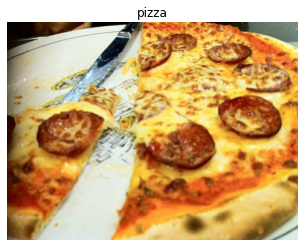

In [7]:
#view a random image from the training dataset

img = view_random_image(target_dir='pizza_steak/train/',target_class='pizza')

In [8]:
img.dtype

dtype('uint8')

In [9]:
import tensorflow as tf
tf.constant(img)

<tf.Tensor: shape=(383, 512, 3), dtype=uint8, numpy=
array([[[  7,   2,   0],
        [  7,   2,   0],
        [  6,   1,   0],
        ...,
        [114, 136, 124],
        [114, 135, 126],
        [111, 132, 123]],

       [[  8,   3,   0],
        [  7,   2,   0],
        [  6,   1,   0],
        ...,
        [118, 140, 128],
        [121, 143, 131],
        [119, 140, 131]],

       [[  8,   3,   0],
        [  8,   3,   0],
        [  7,   2,   0],
        ...,
        [119, 141, 129],
        [121, 143, 131],
        [121, 143, 131]],

       ...,

       [[ 86,  70,  47],
        [ 91,  75,  52],
        [ 98,  82,  57],
        ...,
        [220, 232, 222],
        [219, 231, 221],
        [219, 231, 221]],

       [[ 94,  76,  54],
        [ 99,  81,  57],
        [107,  89,  65],
        ...,
        [219, 232, 222],
        [218, 231, 221],
        [218, 231, 221]],

       [[100,  82,  60],
        [104,  86,  62],
        [111,  93,  69],
        ...,
        [219, 232, 22

In [10]:
# View the image shape
img.shape

(383, 512, 3)

Looking at the image shape more closely, you'll see it's in the form (Width, Height, Colour Channels).

In our case, the width and height vary but because we're dealing with colour images, the colour channels value is always 3. This is for different values of red, green and blue (RGB) pixels.

You'll notice all of the values in the img array are between 0 and 255. This is because that's the possible range for red, green and blue values.

For example, a pixel with a value red=0, green=0, blue=255 will look very blue.

So when we build a model to differentiate between our images of pizza and steak, it will be finding patterns in these different pixel values which determine what each class looks like.

🔑 Note: As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to scale (also referred to as normalize) their pixel values by dividing the image arrays by 255.

In [11]:
 #normalize
img/255 

array([[[0.02745098, 0.00784314, 0.        ],
        [0.02745098, 0.00784314, 0.        ],
        [0.02352941, 0.00392157, 0.        ],
        ...,
        [0.44705882, 0.53333333, 0.48627451],
        [0.44705882, 0.52941176, 0.49411765],
        [0.43529412, 0.51764706, 0.48235294]],

       [[0.03137255, 0.01176471, 0.        ],
        [0.02745098, 0.00784314, 0.        ],
        [0.02352941, 0.00392157, 0.        ],
        ...,
        [0.4627451 , 0.54901961, 0.50196078],
        [0.4745098 , 0.56078431, 0.51372549],
        [0.46666667, 0.54901961, 0.51372549]],

       [[0.03137255, 0.01176471, 0.        ],
        [0.03137255, 0.01176471, 0.        ],
        [0.02745098, 0.00784314, 0.        ],
        ...,
        [0.46666667, 0.55294118, 0.50588235],
        [0.4745098 , 0.56078431, 0.51372549],
        [0.4745098 , 0.56078431, 0.51372549]],

       ...,

       [[0.3372549 , 0.2745098 , 0.18431373],
        [0.35686275, 0.29411765, 0.20392157],
        [0.38431373, 0

# build a convolutional neural network to find a patterns in our images

*load images

*preprocess

*build a CNN

*compile

*fit the model

In [12]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
#ser the seed
tf.random.set_seed(42)

#preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

#Setup paths to our data directories
train_dir = 'pizza_steak/train'
test_dir = 'pizza_steak/test'

#import data from directories and turn it into batchec(batch normalization is achieved through a normalization step that fixes the means and variances of each layer's inputs.)
train_data = train_datagen.flow_from_directory(directory=train_dir, 
                                               batch_size=32,
                                               target_size=(224,224), 
                                               class_mode='binary',
                                               seed=42)#change our data to new size

valid_data = train_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224,224), 
                                               class_mode='binary',
                                               seed=42)#change our data to new size

#build a CNN model
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 63s 1s/step - loss: 0.5597 - accuracy: 0.7007 - val_loss: 0.4081 - val_accuracy: 0.8160
Epoch 2/5
47/47 [==============================] - 66s 1s/step - loss: 0.4171 - accuracy: 0.8120 - val_loss: 0.3733 - val_accuracy: 0.8520
Epoch 3/5
47/47 [==============================] - 66s 1s/step - loss: 0.3775 - accuracy: 0.8273 - val_loss: 0.3121 - val_accuracy: 0.8740
Epoch 4/5
47/47 [==============================] - 68s 1s/step - loss: 0.3375 - accuracy: 0.8587 - val_loss: 0.3483 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 62s 1s/step - loss: 0.3106 - accuracy: 0.8633 - val_loss: 0.3322 - val_accuracy: 0.8580


In [14]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

# Improving the model


In [17]:
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)),# dense layers expect a 1-dimensional vector as input
    tf.keras.layers.Dense(100, activation='relu'),# increase number of neurons from 4 to 100 (for each layer)
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),# add an extra layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, 
                        validation_steps=len(valid_data))


Epoch 1/5
47/47 [==============================] - 17s 364ms/step - loss: 3.1266 - accuracy: 0.6147 - val_loss: 3.0657 - val_accuracy: 0.5380
Epoch 2/5
47/47 [==============================] - 15s 319ms/step - loss: 1.2336 - accuracy: 0.6493 - val_loss: 0.8465 - val_accuracy: 0.7660
Epoch 3/5
47/47 [==============================] - 15s 318ms/step - loss: 0.9637 - accuracy: 0.7060 - val_loss: 1.3446 - val_accuracy: 0.5600
Epoch 4/5
47/47 [==============================] - 16s 335ms/step - loss: 0.5978 - accuracy: 0.7473 - val_loss: 0.4483 - val_accuracy: 0.7980
Epoch 5/5
47/47 [==============================] - 15s 318ms/step - loss: 0.4333 - accuracy: 0.8087 - val_loss: 0.4702 - val_accuracy: 0.7980


In [18]:
# Check out model_3 architecture
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


# Binary classification
We just went through a whirlwind of steps:

+Become one with the data (visualize, visualize, visualize...)

+Preprocess the data (prepare it for a model)

+Create a model (start with a baseline)

+Fit the model

+Evaluate the model

+Adjust different parameters and improve model (try to beat your baseline)

+Repeat until satisfied

# 1.import data

Image shape: (288, 512, 3)
Image shape: (384, 512, 3)


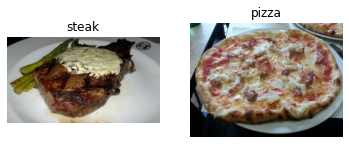

In [19]:
#visualize data
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image('pizza_steak/train/','steak')
plt.subplot(1,2,2)
pizza_img = view_random_image('pizza_steak/train/','pizza')

# 2. Preprocess the data

In [20]:
#preprocess the data
train_dir = 'pizza_steak/train/'
test_dir = 'pizza_steak/test/'

In [21]:
# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

the batch size is the number of samples that will be passed through to the network at one time.
example: batch=10   1000images/10=100 batches per epoch

larger batches = faster training

The ImageDataGenerator class helps us prepare our images into batches as well as perform transformations on them as they get loaded into the model.

In [41]:
#load in our image data from directories and turn them into batches

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                              target_size=(224,224),
                                              class_mode='binary',
                                              batch_size=32) #32 is good for most of the model
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                              target_size=(224,224),
                                              class_mode='binary',
                                              batch_size=32)


#if our image data from dataframe, we should use flow_from_daraframe

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [42]:
#get a sample of a train data batch

images, labels = train_data.next()
len(images), len(labels)

(32, 32)

In [43]:
#how many batches are there in epoch
len(train_data)

#1500/32=46.87

47

In [44]:
#get the first two images(tensor)
images[:2], images[0].shape

(array([[[[0.63529414, 0.65882355, 0.61960787],
          [0.63529414, 0.65882355, 0.61960787],
          [0.6431373 , 0.6666667 , 0.627451  ],
          ...,
          [0.52156866, 0.52156866, 0.4901961 ],
          [0.52156866, 0.50980395, 0.48235297],
          [0.50980395, 0.49803925, 0.47058827]],
 
         [[0.64705884, 0.67058825, 0.6313726 ],
          [0.6431373 , 0.6666667 , 0.627451  ],
          [0.64705884, 0.67058825, 0.6313726 ],
          ...,
          [0.5294118 , 0.5294118 , 0.4901961 ],
          [0.5411765 , 0.5411765 , 0.5019608 ],
          [0.5254902 , 0.5137255 , 0.4784314 ]],
 
         [[0.65882355, 0.68235296, 0.6431373 ],
          [0.65882355, 0.68235296, 0.6431373 ],
          [0.654902  , 0.6784314 , 0.6392157 ],
          ...,
          [0.54509807, 0.54509807, 0.5058824 ],
          [0.54901963, 0.54901963, 0.5019608 ],
          [0.5294118 , 0.5294118 , 0.48235297]],
 
         ...,
 
         [[0.7686275 , 0.7843138 , 0.7254902 ],
          [0.76470

In [45]:
#view the first batch of labels
labels

array([1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

# 3.create a CNN model (start with a baseline)

In [46]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [47]:
model_4 = Sequential([
    Conv2D(filters=10,#number of filters. higher= more complex
          kernel_size=3,# size of each filter
          strides=1,#the size of the step the filter take across an input
          padding='valid', #valid means output shape gets compressed
          activation='relu',
          input_shape=(224,224,3)),# input layer(soecify input shape)
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')# output layer(working with binary classification)
])

The typical CNN structure of:

Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output
Let's discuss some of the components of the Conv2D layer:

The "2D" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually. 



filters - these are the number of "feature extractors" that will be moving over our images.(decide how many filters should pass over an input tensor)

kernel_size - the size of our filters, for example, a kernel_size of (3, 3) (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract. (shape of filter)

stride - the number of pixels a filter will move across as it covers the image. A stride of 1 means the filter moves across each pixel 1 by 1. A stride of 2 means it moves 2 pixels at a time.(steps  of filters)

padding - this can be either 'same' or 'valid', 'same' adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as 'valid' (default) cuts off excess pixels where the filter doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.(Padding conserves data at the borders of activation maps, which leads to better performance   0=same, 1=valid or compress)

pooling : Progressive reduction of the spatial size of feature map as we move from one convolution layer to the next, thus helping to reduce number of parameters;

 we see the filters in a convolutional layer learn to detect abstract concepts, like the boundary of a face or the shoulders of a person. By stacking layers of convolutions on top of each other, we can get more abstract and in-depth information from a CNN.

In [48]:
#compile
model_4.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])


In [49]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_8 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_9 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_4 (Flatten)         (None, 475240)            0         
                                                                 
 dense_9 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


# fit the model

In [50]:
#check the length of trainig and test data generators(batches)
len(train_data),len(test_dara)

(47, 16)

In [51]:
history_4 = model_4.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=len(test_data)
                       )

Epoch 1/5
47/47 [==============================] - 80s 2s/step - loss: 1.5344 - accuracy: 0.5467 - val_loss: 0.5564 - val_accuracy: 0.6740
Epoch 2/5
47/47 [==============================] - 74s 2s/step - loss: 0.4809 - accuracy: 0.7700 - val_loss: 0.4431 - val_accuracy: 0.8060
Epoch 3/5
47/47 [==============================] - 74s 2s/step - loss: 0.3158 - accuracy: 0.8807 - val_loss: 0.3934 - val_accuracy: 0.8260
Epoch 4/5
47/47 [==============================] - 72s 2s/step - loss: 0.1525 - accuracy: 0.9587 - val_loss: 0.3971 - val_accuracy: 0.8340
Epoch 5/5
47/47 [==============================] - 70s 2s/step - loss: 0.0756 - accuracy: 0.9873 - val_loss: 0.3912 - val_accuracy: 0.8520


# 5. Evaluate the model

In [53]:
model_1.evaluate(test_data)

16/16 [==============================] - 4s 227ms/step - loss: 0.3322 - accuracy: 0.8580


[0.33220207691192627, 0.8579999804496765]

In [54]:
model_4.evaluate(test_data)

16/16 [==============================] - 6s 349ms/step - loss: 0.3912 - accuracy: 0.8520


[0.39118391275405884, 0.8519999980926514]

<AxesSubplot:>

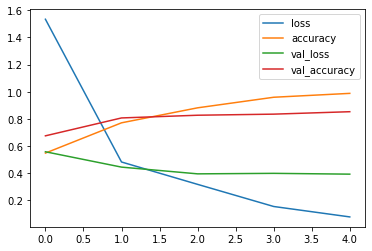

In [61]:
import pandas as pd
pd.DataFrame(history_4.history).plot()

In [62]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

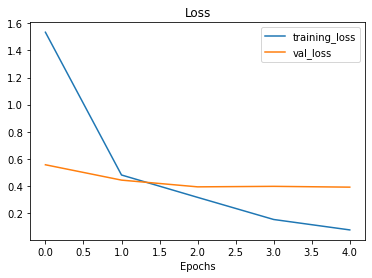

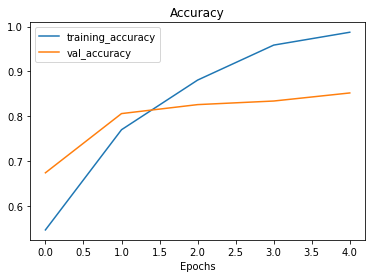

In [63]:
# Check out the loss curves of model_4
plot_loss_curves(history_4)


The ideal position for these two curves is to follow each other. If anything, the validation curve should be slightly under the training curve. If there's a large gap between the training curve and validation curve, it means your model is probably overfitting.

# 6.Adjust the model parameters

 there are even a few more things we could try to further overfit our model:

Increase the number of convolutional layers.

Increase the number of convolutional filters.

Add another dense layer to the output of our flattened layer.

reduce overfitting:
    add data augmentation
    add regularization layers(such as MaxPool2D)
    add more data

In [64]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [65]:
# Check out the model architecture
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

In [66]:
model_5.compile(loss='binary_crossentropy',
               optimizer= Adam(),
               metrics=['accuracy'])

In [67]:
history_5 = model_5.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=len(valid_data)
                       )

Epoch 1/5
47/47 [==============================] - 39s 766ms/step - loss: 0.5844 - accuracy: 0.7027 - val_loss: 0.4268 - val_accuracy: 0.8160
Epoch 2/5
47/47 [==============================] - 34s 726ms/step - loss: 0.4369 - accuracy: 0.8087 - val_loss: 0.3717 - val_accuracy: 0.8360
Epoch 3/5
47/47 [==============================] - 36s 756ms/step - loss: 0.3940 - accuracy: 0.8367 - val_loss: 0.3278 - val_accuracy: 0.8620
Epoch 4/5
47/47 [==============================] - 36s 760ms/step - loss: 0.3667 - accuracy: 0.8380 - val_loss: 0.3204 - val_accuracy: 0.8660
Epoch 5/5
47/47 [==============================] - 36s 751ms/step - loss: 0.3458 - accuracy: 0.8587 - val_loss: 0.3072 - val_accuracy: 0.8680


In [68]:
model_5.evaluate(test_data)

16/16 [==============================] - 6s 337ms/step - loss: 0.3072 - accuracy: 0.8680


[0.30722174048423767, 0.8679999709129333]

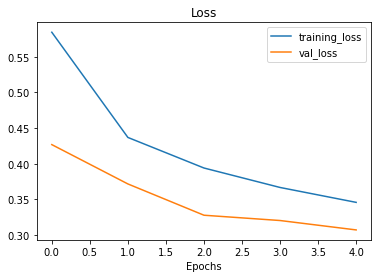

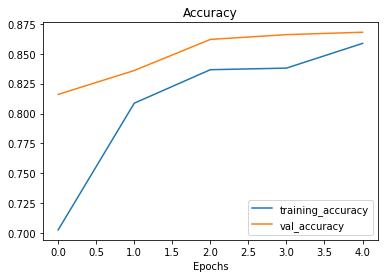

In [69]:
# Plot loss curves of model_5 results
plot_loss_curves(history_5)

Nice! We can see the training curves get a lot closer to eachother. However, our the validation loss looks to start increasing towards the end and in turn potentially leading to overfitting.

# try another method of overfitting prevention, data augmentation:

In [70]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

Data augmentation is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

In [71]:
#import data and augment it from training directory

print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [73]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next()

In [79]:
images.shape

(32, 224, 224, 3)

In [80]:
len(images),1500/32, len(labels)

(32, 46.875, 32)

In [81]:
len(augmented_images),1500/32, len(augmented_images)

(32, 46.875, 32)

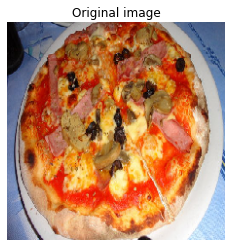

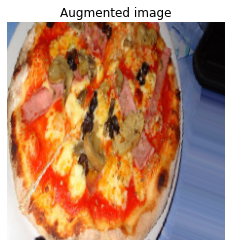

In [76]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

As for how much to data augment, there's no set practice for this. Best to check out the options in the ImageDataGenerator class and think about how a model in your use case might benefit from some data augmentation.

In [82]:
# Create the model (same as model_5)
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 81s 2s/step - loss: 0.7112 - accuracy: 0.4413 - val_loss: 0.6852 - val_accuracy: 0.6020
Epoch 2/5
47/47 [==============================] - 76s 2s/step - loss: 0.6923 - accuracy: 0.5507 - val_loss: 0.6868 - val_accuracy: 0.5800
Epoch 3/5
47/47 [==============================] - 75s 2s/step - loss: 0.6861 - accuracy: 0.5813 - val_loss: 0.6673 - val_accuracy: 0.5520
Epoch 4/5
47/47 [==============================] - 75s 2s/step - loss: 0.6898 - accuracy: 0.5200 - val_loss: 0.6774 - val_accuracy: 0.6820
Epoch 5/5
47/47 [==============================] - 69s 1s/step - loss: 0.6749 - accuracy: 0.5560 - val_loss: 0.6572 - val_accuracy: 0.6220


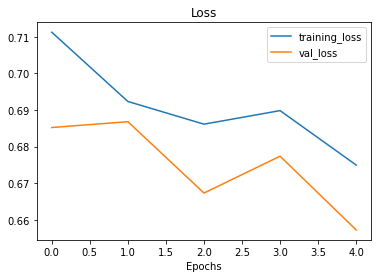

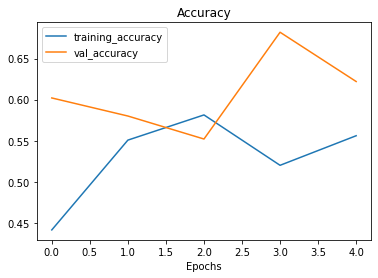

In [83]:
plot_loss_curves(history_6)

our model didin't get very good results on the training set.
let's shuffle our augmented training data and train another model

In [84]:
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True)

Found 1500 images belonging to 2 classes.


In [85]:
# Create the model (same as model_5 and model_6)
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 84s 2s/step - loss: 0.6453 - accuracy: 0.6107 - val_loss: 0.5606 - val_accuracy: 0.6840
Epoch 2/5
47/47 [==============================] - 76s 2s/step - loss: 0.5612 - accuracy: 0.7240 - val_loss: 0.4685 - val_accuracy: 0.7660
Epoch 3/5
47/47 [==============================] - 70s 1s/step - loss: 0.5196 - accuracy: 0.7487 - val_loss: 0.3998 - val_accuracy: 0.8260
Epoch 4/5
47/47 [==============================] - 72s 2s/step - loss: 0.5001 - accuracy: 0.7493 - val_loss: 0.3763 - val_accuracy: 0.8340
Epoch 5/5
47/47 [==============================] - 70s 1s/step - loss: 0.4783 - accuracy: 0.7747 - val_loss: 0.3646 - val_accuracy: 0.8540


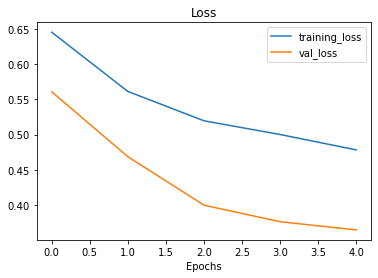

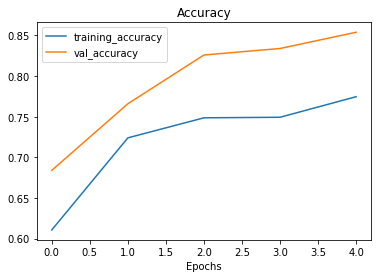

In [86]:
plot_loss_curves(history_7)

shuffle=True : This means the model was able to see examples of both pizza and steak images in each batch and in turn be evaluated on what it learned from both images rather than just one kind.

# repeat until satisfied

there are a few things we could try to continue to improve our model:

Increase the number of model layers (e.g. add more convolutional layers).

Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).

Train for longer (more epochs).

Finding an ideal learning rate.

Get more data (give the model more opportunities to learn).

Use transfer learning to leverage what another image model has learned and adjust it for our own use case.

# Making a prediction with our trained model

In [89]:
# view the image we're going to test on.


import zipfile
# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [91]:
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_all_data'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")  

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [109]:
#setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [110]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [114]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image
  return img

Image shape: (384, 512, 3)


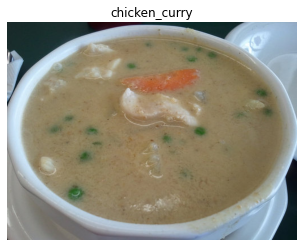

In [120]:
#view a random image from the training dataset

img = view_random_image(target_dir=train_dir,target_class=random.choice(class_names))

# preprocess the data

In [136]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# create model

In [137]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_8.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [138]:
history_8 = model_8.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 282s 1s/step - loss: 2.1856 - accuracy: 0.1981 - val_loss: 2.0067 - val_accuracy: 0.2804
Epoch 2/5
235/235 [==============================] - 294s 1s/step - loss: 1.8864 - accuracy: 0.3449 - val_loss: 1.8907 - val_accuracy: 0.3168
Epoch 3/5
235/235 [==============================] - 302s 1s/step - loss: 1.5286 - accuracy: 0.4952 - val_loss: 1.9401 - val_accuracy: 0.3544
Epoch 4/5
235/235 [==============================] - 303s 1s/step - loss: 0.9402 - accuracy: 0.6955 - val_loss: 2.3081 - val_accuracy: 0.3068
Epoch 5/5
235/235 [==============================] - 294s 1s/step - loss: 0.3809 - accuracy: 0.8831 - val_loss: 3.2735 - val_accuracy: 0.2800


In [139]:
model_8.evaluate(test_data)

79/79 [==============================] - 30s 372ms/step - loss: 3.2735 - accuracy: 0.2800


[3.27353572845459, 0.2800000011920929]

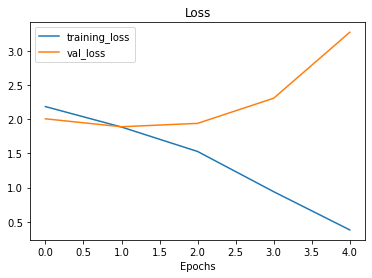

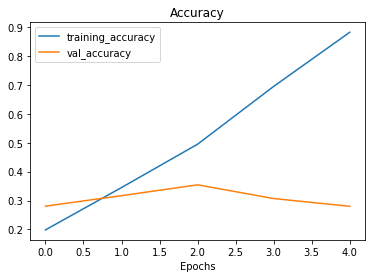

In [140]:
plot_loss_curves(history_8)

our model is overfitting

# adjust the model hyperparameters (to reduce overfitting)

So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

Get more data - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.

Simplify model - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.

Use data augmentation - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.

Use transfer learning - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

In [142]:
#let's try to remove 2 convolutional layers
# Create our model (a clone of model_8, except to be multi-class)
model_9 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
 # Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  #Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_9.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [143]:
history_9 = model_9.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 172s 728ms/step - loss: 2.1822 - accuracy: 0.2236 - val_loss: 2.0259 - val_accuracy: 0.2724
Epoch 2/5
235/235 [==============================] - 181s 769ms/step - loss: 1.8303 - accuracy: 0.3763 - val_loss: 1.9219 - val_accuracy: 0.3344
Epoch 3/5
235/235 [==============================] - 186s 789ms/step - loss: 1.4477 - accuracy: 0.5284 - val_loss: 2.0797 - val_accuracy: 0.2976
Epoch 4/5
235/235 [==============================] - 180s 767ms/step - loss: 0.9700 - accuracy: 0.6911 - val_loss: 2.3295 - val_accuracy: 0.2884
Epoch 5/5
235/235 [==============================] - 180s 765ms/step - loss: 0.5542 - accuracy: 0.8335 - val_loss: 2.8538 - val_accuracy: 0.2812


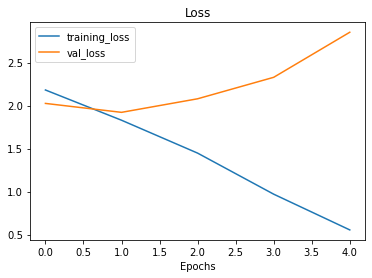

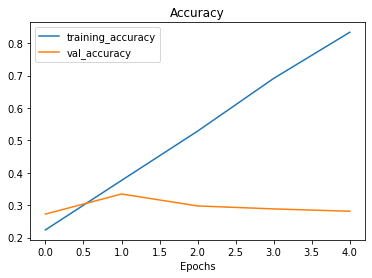

In [144]:
plot_loss_curves(history_9)

sounds our simplifying the model didnt work

# data augmentation to reduce overfitting

In [150]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             #shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='categorical',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle


Found 7500 images belonging to 10 classes.


In [151]:
#create anothekerasodel but this time we'll fit it on the augmented training data
model_10 = tf.keras.models.clone_model(model_8)

# Compile the model
model_10.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [152]:
history_10 = model_10.fit(train_data_augmented,  
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 486s 2s/step - loss: 2.3542 - accuracy: 0.0837 - val_loss: 2.3025 - val_accuracy: 0.0972
Epoch 2/5
235/235 [==============================] - 451s 2s/step - loss: 2.3038 - accuracy: 0.0873 - val_loss: 2.3024 - val_accuracy: 0.1008
Epoch 3/5
235/235 [==============================] - 435s 2s/step - loss: 2.3039 - accuracy: 0.0649 - val_loss: 2.3022 - val_accuracy: 0.0956
Epoch 4/5
235/235 [==============================] - 865s 4s/step - loss: 2.3045 - accuracy: 0.0743 - val_loss: 2.3025 - val_accuracy: 0.0992
Epoch 5/5
235/235 [==============================] - 467s 2s/step - loss: 2.3038 - accuracy: 0.0733 - val_loss: 2.3023 - val_accuracy: 0.1000


In [153]:
model_8.evaluate(test_data)

79/79 [==============================] - 41s 504ms/step - loss: 2.3033 - accuracy: 0.1060


[2.303344488143921, 0.10599999874830246]

In [154]:
model_10.evaluate(test_data)

79/79 [==============================] - 41s 514ms/step - loss: 2.3023 - accuracy: 0.1000


[2.302321672439575, 0.10000000149011612]

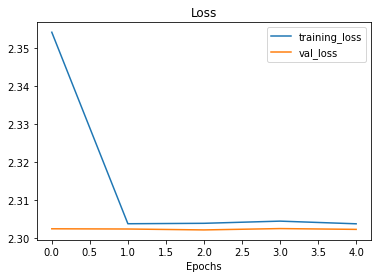

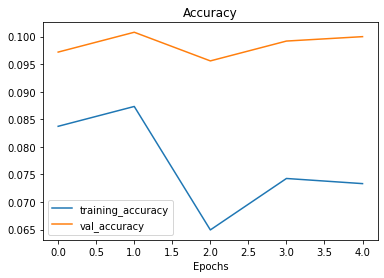

In [155]:
plot_loss_curves(history_10)

that's look much better

# repeat until satisfied

We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer(more epochs). 


# Making a prediction with our trained model

In [ ]:
# What classes has our model been trained on?
class_names
     

In [2]:


# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
# Make a prediction using model_10
pred_and_plot(model=model_10, 
              filename="03-steak.jpeg", 
              class_names=class_names)